In [56]:
#
# LF test with noise
# C = S + N, where noise N = sigma^2 I, where I is the identity matrix
#
# We generate 20 values of parameters x for function logLF(x)
# We chose our parameters around the value of Boltzmann code generated C_3
# CAMB generated C_3 equals 5.88275e-10
#
# 1. Set all C_l = 0 except C_3  DONE
#
# 2. LF is based on a matrix C that only has a P_3 term. DONE
#
# 3. Add to that matrix a white noise term (sigma^2 on the diagonal). DONE
#
# 4. LF now has *exactly two* free parameters, C_3 and sigma^2. DONE
#
# 5. What is LF vs C_3 (at, perhaps, a couple values of sigma^2)? PROBLEM!
#
# 6. over-plot |a_3m|^2 values
#
# You could initialize that parameter to the empirical variance!
#

In [57]:
%matplotlib inline
import math
import matplotlib.pyplot as plt 
import numpy as np
import healpy as hp
import pyfits as pf
import astropy as ap
import os
from scipy.special import eval_legendre  ##special scipy function

In [58]:
#
# Review of Likelihood Formalism:
#
# -2 loglikelihood is
# -2 ln L \propto m^T C^-1 m + lnDet C
# where C = S + N
# We are working with noiseless maps, N = 0, so C = S
#
# In real space, 
# data: the temperature map, 
# parameters: theoretical CAMB generated C_l, C^theory_l 
#
# m = array of temperature pixels
# S = S_ij
# N = diagonal noise (but here it is noiseless! N=0)
#
# In spherical harmonic space
# data: the Healpix anafast outputarray of a_lm (or similarly, \hat{C}_l )
# parameters: the theoretical C_l
#
# m = a_lm coefficients
# S is diagonal (C_2, C_3, etc.)
# N is non-sparse matrix (but here it is noiseless! N=0)
#
#
# NOTE: The correct standard is to systematically remove the monopole, dipole terms l=0,l=1
#       Also, we use in the following lmax = 2*nside

In [59]:
cd ~/Desktop/CMBintheLikeHoodz/Likelihood_Comparison

/Users/evanbiederstedt/Desktop/CMBintheLikeHoodz/Likelihood_Comparison


In [60]:
camb1 = "camb_nside16_lmax32_alms.fits"
camb2 = "camb_nside16_lmax32_map.fits"
camb3 = "camb_nside16_lmax32_scalcls.fits"
planck1 = "100GHz_nside16_lmax32_cls.fits"
planck2 = "100GHz_nside16_lmax32_cmb_alm.fits"
planck3 = "100GHz_nside16_lmax32_sky_alm.fits"
planck4 = "100GHz_nside16_lmax32_skymap.fits"

nside = 16

In [61]:
npix = 12*(nside**2) #total number of pixels, npix
LMAX = ((2*nside)) #maximum l of the power spectrum C_l
heal_npix = hp.nside2npix(nside) # Healpix calculated npix

print "The total number of pixels is " + str(npix)
print "The maximum ell of the power spectrum C_l set to lmax = 2*nside " +str(LMAX)
print "Healpix tells me total number of pixels npix is equal to " + str(heal_npix)

The total number of pixels is 3072
The maximum ell of the power spectrum C_l set to lmax = 2*nside 32
Healpix tells me total number of pixels npix is equal to 3072


In [62]:
#
# Begin with a Munich Planck-simulated map, and CAMB Boltzmann-code generated C_l values
#

In [63]:
# Theoretical scalar C_l array, CAMB
#
# open a FITS file, theoretical C_l values generated by CAMB
# type()=pyfits.hdu.hdulist.HDUList
cl_open = pf.open(camb3)
# recall camb3 = "camb_nside16_lmax32_scalcls.fits"

In [64]:
theoryCls_arr1 = cl_open[1].data
print theoryCls_arr1[:10]
# Recall there are four columns: temp, E pol, B pol, grad-temp cross terms
# first two values are zero, i.e. monopole, dipole
# XXX.field() references columns by 0-index
# field(0) is temperature values
# all Cl scalar temp values put into ndarray
# type()=numpy.ndarray

[(0.0, 0.0, 0.0, 0.0) (0.0, 0.0, 0.0, 0.0)
 (1.2639207e-09, 5.5308927e-14, 0.0, 3.6016001e-12)
 (5.8827504e-10, 4.5345086e-14, 0.0, 2.2704995e-12)
 (3.2867314e-10, 3.0680604e-14, 0.0, 1.4030458e-12)
 (2.065753e-10, 1.8198442e-14, 0.0, 8.6680196e-13)
 (1.4100289e-10, 9.6222612e-15, 0.0, 5.4035639e-13)
 (1.0233801e-10, 4.5884262e-15, 0.0, 3.3960166e-13)
 (7.7812937e-11, 2.0448748e-15, 0.0, 2.1437516e-13)
 (6.1362422e-11, 9.4503657e-16, 0.0, 1.3715881e-13)]


In [65]:
cltemps = theoryCls_arr1.field(0) 
print cltemps
print "The length of the array of theoretical Cl's is " +str(len(cltemps))
print "The array contains [C_0, C_1, C_2,..., C_" +str(len(cltemps)-1) + "]"
#print type(cltemps)=numpy.ndarray

[  0.00000000e+00   0.00000000e+00   1.26392075e-09   5.88275040e-10
   3.28673144e-10   2.06575299e-10   1.41002890e-10   1.02338013e-10
   7.78129366e-11   6.13624221e-11   4.98225766e-11   4.14123076e-11
   3.50811741e-11   3.01814025e-11   2.63133803e-11   2.32104266e-11
   2.06850804e-11   1.86004823e-11   1.68565179e-11   1.53792031e-11
   1.41130128e-11   1.30162998e-11   1.20591913e-11   1.12186076e-11
   1.04760627e-11   9.81660760e-12   9.22804801e-12   8.70035207e-12
   8.22520958e-12   7.79568684e-12   7.40596039e-12   7.05096528e-12
   6.72585642e-12]
The length of the array of theoretical Cl's is 33
The array contains [C_0, C_1, C_2,..., C_32]


In [66]:
# remove monopole l=0 and dipole l=1
theoryCl = cltemps[2:]
# len(theoryCl) = 31
print theoryCl
# theoryCl is np.ndarray of theoretical [C_2, C_3, C_4, ..., C_32]

[  1.26392075e-09   5.88275040e-10   3.28673144e-10   2.06575299e-10
   1.41002890e-10   1.02338013e-10   7.78129366e-11   6.13624221e-11
   4.98225766e-11   4.14123076e-11   3.50811741e-11   3.01814025e-11
   2.63133803e-11   2.32104266e-11   2.06850804e-11   1.86004823e-11
   1.68565179e-11   1.53792031e-11   1.41130128e-11   1.30162998e-11
   1.20591913e-11   1.12186076e-11   1.04760627e-11   9.81660760e-12
   9.22804801e-12   8.70035207e-12   8.22520958e-12   7.79568684e-12
   7.40596039e-12   7.05096528e-12   6.72585642e-12]


In [67]:
# Our input data is Gaerching generated, noiseless full-sky map
# Temperature map: here we use Planck simulated map from Munich, not CAMB map
# http://gavo.mpa-garching.mpg.de/planck/
#
# Read in with Healpy routine/function
#
# Use planck4 = "100GHz_nside16_lmax32_skymap.fits"
# This is a simulated data, 100GHz (where CMB dominates), no foregrounds
# 
mapread_camb2 = hp.read_map(camb2) # Healpix routine, input the sky map

NSIDE = 16
ORDERING = RING in fits file


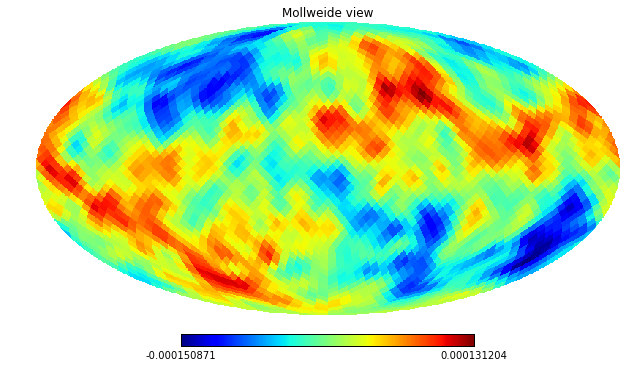

In [68]:
hp.mollview(mapread_camb2) # visualization of full-sky CMB map, nside=16, lmax=32

In [69]:
# The uploaded temperature map is mapread_planck4 = hp.read_map(planck4)
print type(mapread_camb2) # type(mapread_planck4) = np.ndarray
print mapread_camb2.shape # mapread_planck4.shape = (3072, ) = (N_pix, )
#
# rename array for convenience
tempval = mapread_camb2
#print tempval

<type 'numpy.ndarray'>
(3072,)


In [70]:
# Next, we use healpy map2alm to tranform to alm values
# Our input data is CAMB generated, noiseless full-sky map
# We calculate an array of a_lm from this by using Healpix map2alm, a subroutine of anafast
#
# map2alm only outputs m >=0 values, because m = -l values are equivalent to m = +l values
#
# Using map2alm, the length of the alm array is expected to be:
# (mmax * (2 * lmax + 1 - mmax)) / 2 + lmax + 1)"
#
# For mmax = lmax, this is l(l+1)/2 + l + 1
# i.e. 
# l = 0, there is 1
# l = 1, there is 3
# l = 2, there is 6
# l = 3, there is 10
# l = 4, there is 15
# etc.
almarr = hp.map2alm(mapread_camb2)                # This is an array of a_lm values
print "The array of spherical harmonic coefficients a_lm is"
#print almarr
print "The arr.shape is " + str(almarr.shape)
print "The length of a_lm array is " + str(len(almarr))
#
print "For l=3, map2alm gives (a_00, a_10, a_11, a_20, a_21, a_22, a_30, a_31, a_32, a_33)"
print "However, this is NOT the order of the output! See below"
# In the Fortran F90 subroutines, complex alm are stored in an array that has 
# two dimensions to contain coefficients for positive and negative m values.
# Healpy doesn't do this....I think

print "============================="
print "============================="
print "Check indices with healpy.sphtfunc.Alm.getidx(lmax, l, m)"
print "Default ordering of healpy.map2alm() output is "
print "(0,0), (1,0), ..., (lmax, 0),"
print "(1,1), (2,1), ...., (lmax, 1),"
print "(2,2), .... (lmax, 2),(3,3), ...., (lmax, 3), etc. , .... (lmax, lmax)."


The array of spherical harmonic coefficients a_lm is
The arr.shape is (1176,)
The length of a_lm array is 1176
For l=3, map2alm gives (a_00, a_10, a_11, a_20, a_21, a_22, a_30, a_31, a_32, a_33)
However, this is NOT the order of the output! See below
Check indices with healpy.sphtfunc.Alm.getidx(lmax, l, m)
Default ordering of healpy.map2alm() output is 
(0,0), (1,0), ..., (lmax, 0),
(1,1), (2,1), ...., (lmax, 1),
(2,2), .... (lmax, 2),(3,3), ...., (lmax, 3), etc. , .... (lmax, lmax).


In [71]:
# ==========================
# DEMONSTRATION
# Notice how a_lm is indexed
# ==========================

mmm = np.arange(12) # define a map, i.e. an array of 12 "pixels"
lmaxxx = 4
alm = hp.map2alm(mmm, lmax=lmaxxx) # spherical harmonic transform
lm = hp.map2alm(mmm, lmax=lmaxxx) # spherical harmonic transform
print(alm)
print(alm.shape)

# So alm is actually a 1D vector.
# How is alm indexed?


l, m = hp.Alm.getlm(lmax=lmaxxx)
print(l)

print(m)




print "The l values are "+str(l)
print "The m values are "+str(m)
print " (l,m) is in order " +str(list(zip(l,m)))
#
# l, m = hp.Alm.getlm(lmax=lmax)
# print(l)
# [0 1 2 1 2 2]
# print(m)
# [0 0 0 1 1 2]
#
#
# So, for l = 2, m is [0, 1, 2].
#
# ==========================
# Notice how a_lm is indexed
# ==========================
#
#
#

[  1.43186913e+01 +0.00000000e+00j  -9.06158785e+00 +0.00000000e+00j
  -7.57672587e+00 +0.00000000e+00j   5.38292381e+00 +0.00000000e+00j
   2.49127749e+00 +0.00000000e+00j   6.02204636e-01 -2.01587603e+00j
   4.55476051e-16 +1.48937220e-15j   2.43950547e-01 -3.28507898e-01j
  -2.47937026e-17 +3.49331635e-16j   3.65595455e-01 -7.92402132e+00j
   5.92284905e-17 -4.53852723e-15j  -3.16614952e-01 -1.44872968e+01j
  -2.28780515e-03 +4.33449165e-01j  -5.66350430e-16 +1.59192782e-15j
   1.08501635e+01 -3.35394518e-16j]
(15,)
[0 1 2 3 4 1 2 3 4 2 3 4 3 4 4]
[0 0 0 0 0 1 1 1 1 2 2 2 3 3 4]
The l values are [0 1 2 3 4 1 2 3 4 2 3 4 3 4 4]
The m values are [0 0 0 0 0 1 1 1 1 2 2 2 3 3 4]
 (l,m) is in order [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (1, 1), (2, 1), (3, 1), (4, 1), (2, 2), (3, 2), (4, 2), (3, 3), (4, 3), (4, 4)]


In [72]:
# Check with healpy.sphtfunc.Alm.getidx(lmax, l, m)
# Returns index corresponding to (l,m) in an array describing alm up to lmax.
#
ell, emm = hp.Alm.getlm(lmax=32)

print "len(ell) is " +str(len(ell))
print "len(emm) is "+str(len(emm))
print "l values are "+str(ell[:10])
print "m values are "+str(emm[:10])
pairs = list(zip(ell, emm)) # put values together in pairs, zip()
ellemm = np.vstack((ell,emm)).T  # equivalent to list(zip(ell,emm)), but uses numpy throughout
print "Indices for a_lm for lmax (l, m) are:" 
print str(pairs[:50]) # The expected output


len(ell) is 561
len(emm) is 561
l values are [0 1 2 3 4 5 6 7 8 9]
m values are [0 0 0 0 0 0 0 0 0 0]
Indices for a_lm for lmax (l, m) are:
[(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0), (10, 0), (11, 0), (12, 0), (13, 0), (14, 0), (15, 0), (16, 0), (17, 0), (18, 0), (19, 0), (20, 0), (21, 0), (22, 0), (23, 0), (24, 0), (25, 0), (26, 0), (27, 0), (28, 0), (29, 0), (30, 0), (31, 0), (32, 0), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1)]


In [73]:
print ellemm[:10]

[[0 0]
 [1 0]
 [2 0]
 [3 0]
 [4 0]
 [5 0]
 [6 0]
 [7 0]
 [8 0]
 [9 0]]


In [74]:
#
# For our first test, mode l = 3, we need to access a_lm coefficients a_30, a_31, a_32, a_33
# To find this for lmax = 32, we use
# healpy.sphtfunc.Alm.getidx(lmax, l, m)
# Returns index corresponding to (l,m) in an array describing alm up to lmax.
#
# Find the indices
index_a30 = hp.Alm.getidx(lmax=32, l=3, m=0)
index_a31 = hp.Alm.getidx(lmax=32, l=3, m=1)
index_a32 = hp.Alm.getidx(lmax=32, l=3, m=2)
index_a33 = hp.Alm.getidx(lmax=32, l=3, m=3)

In [75]:
print "Index a_30 is " +str(index_a30)
print "Index a_31 is "+str(index_a31)
print "Index a_32 is "+str(index_a32)
print "Index a_33 is "+str(index_a33)

Index a_30 is 3
Index a_31 is 35
Index a_32 is 66
Index a_33 is 96


In [76]:
#
# Create an array with only the values a_3m, i.e. a_30, a_31, a_32, a_33
#
# First convert the array of alm coefficients into a real
#
realalm = almarr.real
#
print realalm[:36]

[  4.27365741e-10   2.29584030e-09  -3.99058124e-05  -3.54786292e-05
   2.10319852e-05   9.87750024e-06   7.97092193e-06  -1.18858780e-05
  -7.27840112e-06   3.61680988e-07  -4.90787138e-06   3.47579016e-06
  -4.30349062e-06  -2.65684938e-07  -1.00274382e-06  -1.12408678e-06
   4.89651663e-06   7.38091856e-07   2.10038079e-07   3.19967529e-06
  -2.82808712e-06   3.98389365e-07   9.92859235e-07   1.12017252e-07
   1.85264741e-06  -1.88066911e-06  -5.47687726e-07  -4.03524074e-08
   6.09934135e-07   6.46948184e-07  -2.27504639e-07   6.00326431e-07
  -1.16138884e-07   6.93299985e-09   3.15959247e-09   6.92273981e-09]


In [77]:
empty_almlist = []
#
a30 = realalm[3]
a31 = realalm[35]
a32 = realalm[66]
a33 = realalm[96]
#
print "a30 is " + str(a30)
print "a31 is " + str(a31)
print "a32 is " + str(a32)
print "a33 is " + str(a33)
#
print str(pairs[3]) # Check with our output above
print str(pairs[35])
print str(pairs[66])
print str(pairs[96])
#
empty_almlist.append(a30)
empty_almlist.append(a31)
empty_almlist.append(a32)
empty_almlist.append(a33)
#
print empty_almlist

a30 is -3.54786291692e-05
a31 is 6.92273981371e-09
a32 is -7.65807282676e-07
a33 is 2.69713402623e-05
(3, 0)
(3, 1)
(3, 2)
(3, 3)
[-3.5478629169177805e-05, 6.9227398137090744e-09, -7.6580728267559654e-07, 2.6971340262298287e-05]


In [78]:
# create array of real-valued alm coefficients, a30 a31 a32 a33
realalm3 = np.asarray(empty_almlist) # np.asarray() converts input into an array
print realalm3

[ -3.54786292e-05   6.92273981e-09  -7.65807283e-07   2.69713403e-05]


In [79]:
# Repeat the above procedure for mode l = 4, i.e. a40 a41 a42 a43 a44
# Find the indices
index_a40 = hp.Alm.getidx(lmax=32, l=4, m=0)
index_a41 = hp.Alm.getidx(lmax=32, l=4, m=1)
index_a42 = hp.Alm.getidx(lmax=32, l=4, m=2)
index_a43 = hp.Alm.getidx(lmax=32, l=4, m=3)
index_a44 = hp.Alm.getidx(lmax=32, l=4, m=4)
#
print "Index a_40 is " +str(index_a40)
print "Index a_41 is "+str(index_a41)
print "Index a_42 is "+str(index_a42)
print "Index a_43 is "+str(index_a43)
print "Index a_44 is "+str(index_a44)
#
# Check with the above ouput
print str(pairs[4]) 
print str(pairs[36])
print str(pairs[67])
print str(pairs[97])
print str(pairs[126])
#
emptylistalm2 = []
#
#print realalm
#
a40 = realalm[4]
a41 = realalm[36]
a42 = realalm[67]
a43 = realalm[97]
a44 = realalm[127]
#
print "a40 is " + str(a40)
print "a41 is " + str(a41)
print "a42 is " + str(a42)
print "a43 is " + str(a43)
print "a44 is " + str(a44)
#
emptylistalm2.append(a40)
emptylistalm2.append(a41)
emptylistalm2.append(a42)
emptylistalm2.append(a43)
emptylistalm2.append(a44)
#
#print emptylistalm2

Index a_40 is 4
Index a_41 is 36
Index a_42 is 67
Index a_43 is 97
Index a_44 is 126
(4, 0)
(4, 1)
(4, 2)
(4, 3)
(4, 4)
a40 is 2.10319852146e-05
a41 is 3.20500644244e-09
a42 is 3.94936640444e-07
a43 is 3.29951851271e-06
a44 is -1.19861955538e-09


In [80]:
# create array of real-valued alm coefficients, a40 a41 a42 a43 a44
realalm4 = np.asarray(emptylistalm2) # np.asarray() converts input into an array
print realalm4

[  2.10319852e-05   3.20500644e-09   3.94936640e-07   3.29951851e-06
  -1.19861956e-09]


In [81]:
# Calculate (abs(alm))**2 i.e. |alm|^2
abs_alm3 = np.absolute(realalm3)
abs_alm4 = np.absolute(realalm4)
print abs_alm3
print abs_alm4
# Now calculate the squares element-wise, x**2
alm3_squared = abs_alm3**2
alm4_squared = abs_alm4**2
print alm3_squared
print alm4_squared

[  3.54786292e-05   6.92273981e-09   7.65807283e-07   2.69713403e-05]
[  2.10319852e-05   3.20500644e-09   3.94936640e-07   3.29951851e-06
   1.19861956e-09]
[  1.25873313e-09   4.79243265e-17   5.86460794e-13   7.27453196e-10]
[  4.42344402e-10   1.02720663e-17   1.55974950e-13   1.08868224e-11
   1.43668884e-18]


In [143]:
# For l = 3 test, we need theoretical value of C_3; ditto for l = 4
print theoryCl
C3 = theoryCl[1]
print "theory C_3 is " +str(C3)
C4 = theoryCl[2]
print "theory C_4 is "+str(C4)

[  1.26392075e-09   5.88275040e-10   3.28673144e-10   2.06575299e-10
   1.41002890e-10   1.02338013e-10   7.78129366e-11   6.13624221e-11
   4.98225766e-11   4.14123076e-11   3.50811741e-11   3.01814025e-11
   2.63133803e-11   2.32104266e-11   2.06850804e-11   1.86004823e-11
   1.68565179e-11   1.53792031e-11   1.41130128e-11   1.30162998e-11
   1.20591913e-11   1.12186076e-11   1.04760627e-11   9.81660760e-12
   9.22804801e-12   8.70035207e-12   8.22520958e-12   7.79568684e-12
   7.40596039e-12   7.05096528e-12   6.72585642e-12]
theory C_3 is 5.88275e-10
theory C_4 is 3.28673e-10


In [83]:
# For lmax = 32, we must create an array of ell values, i.e. [0 1 2 3....31 32]
ell = np.arange(33)
print ell
# 
# Subtract the monopole and dipole, l=0, l=1
ellval = ell[2:]
print ellval 

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32]
[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26
 27 28 29 30 31 32]


In [84]:
# Calculate an array of (2*l + 1)C_l 
# i.e. 5*C_2, 7*C_3, 9*C_4, 11*C_5, 13*C_6, ...
print theoryCl

for i in ellval:
    paramsCl = (2*ellval + 1)*theoryCl # define array (2*l + 1)C_l 
    
print paramsCl

[  1.26392075e-09   5.88275040e-10   3.28673144e-10   2.06575299e-10
   1.41002890e-10   1.02338013e-10   7.78129366e-11   6.13624221e-11
   4.98225766e-11   4.14123076e-11   3.50811741e-11   3.01814025e-11
   2.63133803e-11   2.32104266e-11   2.06850804e-11   1.86004823e-11
   1.68565179e-11   1.53792031e-11   1.41130128e-11   1.30162998e-11
   1.20591913e-11   1.12186076e-11   1.04760627e-11   9.81660760e-12
   9.22804801e-12   8.70035207e-12   8.22520958e-12   7.79568684e-12
   7.40596039e-12   7.05096528e-12   6.72585642e-12]
[  6.31960373e-09   4.11792528e-09   2.95805830e-09   2.27232828e-09
   1.83303757e-09   1.53507020e-09   1.32281992e-09   1.16588602e-09
   1.04627411e-09   9.52483075e-10   8.77029352e-10   8.14897868e-10
   7.63088029e-10   7.19523226e-10   6.82607653e-10   6.51016879e-10
   6.23691163e-10   5.99788922e-10   5.78633527e-10   5.59700893e-10
   5.42663609e-10   5.27274559e-10   5.13327074e-10   5.00646987e-10
   4.89086545e-10   4.78519364e-10   4.68836946e-1

In [85]:
norm = ((2*ellval + 1))/(4*math.pi)
print norm

[ 0.39788736  0.5570423   0.71619724  0.87535219  1.03450713  1.19366207
  1.35281702  1.51197196  1.6711269   1.83028185  1.98943679  2.14859173
  2.30774667  2.46690162  2.62605656  2.7852115   2.94436645  3.10352139
  3.26267633  3.42183128  3.58098622  3.74014116  3.89929611  4.05845105
  4.21760599  4.37676094  4.53591588  4.69507082  4.85422576  5.01338071
  5.17253565]


In [86]:
anafastCl = hp.anafast(mapread_camb2, lmax=32)
#len(anafastCl) = 33
# remove monopole and dipole values, l=0, l=1
hatCl = anafastCl[2:] #len() = 31, type() = np.ndarray
hatC3 = hatCl[1]   # index 0 = C2, 1 = C3, etc.
hatC4 = hatCl[2]
print hatC3
print hatC4

6.49352544114e-10
3.16267210302e-10


In [87]:
# 
# Add a_lm squared, |a_lm|^2
#
print "The values for |a_lm|^2 are : "
print "For |a_3m|**2 such that a_30, a_31, a_32, a_33: "
print str(alm3_squared)
print "And for |a_4m|**2 such that a_40, a_41, a_42, a_43, a_44: "
print str(alm4_squared)



The values for |a_lm|^2 are : 
For |a_3m|**2 such that a_30, a_31, a_32, a_33: 
[  1.25873313e-09   4.79243265e-17   5.86460794e-13   7.27453196e-10]
And for |a_4m|**2 such that a_40, a_41, a_42, a_43, a_44: 
[  4.42344402e-10   1.02720663e-17   1.55974950e-13   1.08868224e-11
   1.43668884e-18]


In [88]:
# =========================================================================
#
# =========================================================================
#
# Data:
#     tempval      # the array of pixel values, (3072,)
#     realalm3     # array of alm values, a30, a31, a32, a33 
#     realalm4     # array of alm values, a40, a41, a42, a43, a44
#     alm3_squared # array of |alm|^2, (abs(a3m))**2
#     alm4_squared # array of |alm|^2, (abs(a4m))**2
#     hatCl        # array of anafast-calculated \hat{C}_l values, l=2 to l=32
#     hatC3        # \hat{C}_3 value
#     hatC4        # \hat{C}_4 value
#
# Parameters:
#     theoryCl     # array of Boltzmann code generated C_l, i.e. C^{theory}_l
#     paramsCl     # array of (2*l + 1)C_l from l=2 to l=lmax
#     C3           # array of C_3 value
#     C4           # array of C_4 value
#    
# Array of ell's: 
#     ellval       # array of l = 2 to l=lmax
#                  # [2 3 4 ... 31 32]
#     norm         # array of (2*l+1)/4pi
#                  # [5/4pi 7/4pi 9/4pi 11/4pi ... 63/4pi 65/4pi]
# =========================================================================
#
# =========================================================================

In [89]:
#
# Next, create the matrix, n_i /cdot n_j
# solely using Healpy routines, i.e. taking the dot product of the vectors
# The result is "dotproductmatrix"
#
# npix = 3072

In [90]:
totalpix = np.arange(npix) # An array indexing the total number of pixels

In [91]:
## healpy.pixelfunc.pix2vec(nside, ipix, nest=False)
## 
## will give three arrays
## arrays of all x values, all y values, all z values
## RING scheme default
# len()=3
# type()=tuple
#
#
vecval = hp.pix2vec(nside, totalpix) #Nside = 16, type()=tuple

In [92]:
vecvalx = vecval[0] #shape (3072,)
vecvaly = vecval[1]
vecvalz = vecval[2]

In [93]:
# First arrange arrays vertically
# numpy.vstack = Stack arrays in sequence vertically (row wise), input sequence of arrays
totalvecval = np.vstack((vecvalx, vecvaly, vecvalz)) #type()=numpy.ndarray

In [94]:
trans = totalvecval.T #transpose

In [95]:
dotproductmatrix = trans.dot(totalvecval) #take the dot product
# dotproductmatrix.shape = (npix, npix) = (3072, 3072)
# type(dotproductmatrix) = np.ndarray

In [96]:
# =========================================================
# =========================================================
#
# \Sum_l (2*l + 1)/4pi C^th_l P_l (dotproductmatrix)
# sum from l=2 to l=lmax
#
# arrays l = [2 3 4 .... lmax]
#        C_l = [C_2 C_3 .... C_lmax]
#
# The correct way to do the summation:
# 
# Step 1: calculate the matrix
#            M = dotproductmatrix
#
# Step 2: evaluate the function P_l(x) for each entry of the matrix
#         OUTPUT: [P_2(M) P_3(M) P_4(M) .... P_lmax(M) ]
#
# Step 3: (2*l +1)/4pi from l=2 to l=lmax
#          [5/4pi 7/4pi 9/4pi 11/4pi .... 65/4pi ]
#
# Step 4: multiply 
#         [5/4pi*P_2(M) + 7/4pi*P_3(M) +...... + 65/4pi*P_32(M)]
#
#
# Step 5: multiply by theoretical CAMB values, [C_2 C_3    C_31 C_32]
#         [5/4pi**C_2* P_2(M) + 7/4pi*C_3* P_3(M) +...... + 65/4pi*C_32* P_32(M)]
#
# Step 6: This is an array of S_ij for each theory C_l, l=2 to l=32
#         
#
#
# =========================================================
# =========================================================

In [97]:
# =========================================================
# =========================================================
#
# Now calculate the likelihood 
# -2lnL \propto m^T C^-1 m + ln det C + N ln (2pi)
#
# First term, m^T C^-1 m is the "model fit term"
# Second term, lndetC is the "complexity penalty"
# Third term, N ln 2pi, a constant
#
# m = tempval
# C = Sij
#
# STEP 1: do inverse of Sij
#        invSij = np.linalg.inv(Sij)
#
# STEP 2: do matrix mulplication, m.T*inv(C)*m
#       
# lnL_modelfit_terms = np.array([np.dot(tempval.T , np.dot(invSij[i] , tempval) ) for i in range(invSij.shape[0])])
#
# STEP 3: do logdet Sij
#
# logdetC = np.linalg.slogdet(Sij) #computes sign and log det C
# logdetC[1]
#
# STEP 4: compute N_pix * 2pi
#
# Npix2pi = (npix)*2*math.pi
#
# Step 5: -2loglikelihood = m.T*inv(C)*m + logdetC[1] + Npix2pi
# 
# =========================================================
# =========================================================

In [98]:
# CODE BOTTLENECK!
# 
# Evaluate Legendre from l=2 to l=lmax for each matrix entry
# [P_2(M) P_3(M) P_4(M) .... P_lmax(M) ]
# 
# WITHOUT BROADCASTING, one would do something like 
# PlMat = []
# for i in ellval:
#    PlMat.append( eval_legendre(i, dotproductmatrix) )
#
#
# With broadcasting, we use
PlMat = eval_legendre(ellval[:, None, None], dotproductmatrix)
# PlMat = [P_2(M) P_3(M) P_4(M) .... P_lmax(M) ]
# PlMat is an array, len()=31 of 31 3072 by 3072 matrices
# PlMat.shape = (31, 3072, 3072)

In [99]:
# multiply PlMat by (2*l+1)/4pi, i.e. norm
norm_matrix = norm[:, None, None] * PlMat
# [5/4pi * P_2(M)  7/4pi * P_3(M) ....   65/4pi * P_32(M)]

In [100]:
# JULY 1, 2015
#
#
# Here we define the LF 
#
# Next we should writen the REAL-space log-likelihood, -2 lnLikefunction
# this is a function of parameters
# plot against parameters, theory C_l
#
# Likelihood function should use -2lnL /propto m^T C^-1 M + log det M
#

In [101]:
# TEST C_3 Likelihood
#
# The covariance matrix is a function of variable "x" where "x" is "C_3", an unknown parameter. 
# 
# Our covariance matrix is therefore S_ij  = 7/4pi * x * P_3(matrix)   
# (We set l=3, i.e. l=3, and P_3)
# 
# The LF is then a function of x, LF(x). This is the only parameter we vary. 
#
# LF = -2loglikelihood /propto T^T inv(S_ij) T + log det (Sij) + N log (2pi)
# 
# We then plot LF(x) vs. parameters x. 
#

In [102]:
# define pixel-value arrays
mT = np.matrix(tempval)     # mT.shape = (1, 3072)
m = np.matrix(tempval).T    # m.shape = (3072, 1)
Npix2pi = (npix)*2*math.pi  # LF constant



In [103]:
print C3 # Boltzmann code CAMB output

5.88275e-10


In [104]:
# generate a number of samples to plot for x
# Boltzmann code value for C3 is 5.88275e-10
# start at 1e-10, end at 9e-10
# default samples generated is 50

In [105]:
vary_x_samples1 = np.linspace(1e-10, 9e-10, num=20 ) #set default num = 20

In [106]:
print vary_x_samples1

[  1.00000000e-10   1.42105263e-10   1.84210526e-10   2.26315789e-10
   2.68421053e-10   3.10526316e-10   3.52631579e-10   3.94736842e-10
   4.36842105e-10   4.78947368e-10   5.21052632e-10   5.63157895e-10
   6.05263158e-10   6.47368421e-10   6.89473684e-10   7.31578947e-10
   7.73684211e-10   8.15789474e-10   8.57894737e-10   9.00000000e-10]


In [107]:
# create Sij array, len()=31, l=2 to l=32
# Sij = norm_matrix * theoryCl[:, None, None]
# [5/4pi*C_2*P_2(M)  7/4pi*C_3*P_3(M) ....   65/4pi*C_32*P_32(M)]

In [108]:
print hatC3  # anafast generated C_l for l = 3 from sky map
print C3     # CAMB generated C_3, Boltzmann code output

6.49352544114e-10
5.88275e-10


In [109]:
print alm3_squared  # a_3m extracted from sky map, absolute value, squared

[  1.25873313e-09   4.79243265e-17   5.86460794e-13   7.27453196e-10]


In [110]:
np.set_printoptions(threshold=100000)  # Default is threshold=1000
## Use this to print all values, disables corner printing

In [111]:
# print out all matrices and parts of the logLF
print vary_x_samples1  # generated from 1e-10 to 9e-10

[  1.00000000e-10   1.42105263e-10   1.84210526e-10   2.26315789e-10
   2.68421053e-10   3.10526316e-10   3.52631579e-10   3.94736842e-10
   4.36842105e-10   4.78947368e-10   5.21052632e-10   5.63157895e-10
   6.05263158e-10   6.47368421e-10   6.89473684e-10   7.31578947e-10
   7.73684211e-10   8.15789474e-10   8.57894737e-10   9.00000000e-10]


In [112]:
print Npix2pi # LogLF constant

19301.9452637


In [113]:
# Calculate the loglikelihood piece by piece, and print
pp = vary_x_samples1

Sij = pp[:, None, None] * norm_matrix[1][None, :, :]
    # Format 7/4pi * param * P_3(M) where param is the parameter we vary, C_l
    # Sij.shape = (50, 3072, 3072)
invSij = np.linalg.inv(Sij)
logdetC = np.linalg.slogdet(Sij)  # returns sign and determinant; use logdetC[1]
    # model_fit_terms = m^T C^-1 m
model_fit_terms = np.array([np.dot(tempval.T , np.dot(invSij[i] , tempval) ) for i in range(invSij.shape[0])])
Test_loglikelihood_func = model_fit_terms + logdetC[1] + Npix2pi

In [114]:
#
# Begin Noise test, N = sigma^2 * Identity
#

In [115]:
#
# The empirical variance from our map is Var(a3m)
#
# print alm3_squared
# [  8.84771791e-13   8.06516529e-18   3.85347491e-12   7.58705140e-11]
#
# Initialize the noise parameter sigma^2 to these values
# The range is wide; try 5e-11 to 5 e-15
#
sigma2 = np.logspace(-12, -16, num=30 ) #set default num = 30
print sigma2

[  1.00000000e-12   7.27895384e-13   5.29831691e-13   3.85662042e-13
   2.80721620e-13   2.04335972e-13   1.48735211e-13   1.08263673e-13
   7.88046282e-14   5.73615251e-14   4.17531894e-14   3.03919538e-14
   2.21221629e-14   1.61026203e-14   1.17210230e-14   8.53167852e-15
   6.21016942e-15   4.52035366e-15   3.29034456e-15   2.39502662e-15
   1.74332882e-15   1.26896100e-15   9.23670857e-16   6.72335754e-16
   4.89390092e-16   3.56224789e-16   2.59294380e-16   1.88739182e-16
   1.37382380e-16   1.00000000e-16]


In [116]:
# For N matrix, set the identity
id_mat = np.identity(3072)
# print id_mat    # This is a (3072, 3072) matrix

In [117]:
noiseresult = sigma2[:, None, None] * id_mat[None, :, :]
#print noiseresult

In [169]:
# Now, rescale
#
# Multiply the CMB maps by 1e6 and the C matrix entries by 1e12 and try again.
#
tempp = (1e6)*tempval # multiply CMB maps by 1e6

def LogLike_wNoise(param, sig):
    # param is our parameter, C_3
    Sij = param[:, None, None] * norm_matrix[1][None, :, :]
    newSij = (1e12)*Sij   # multiply S_ij by 1e12
    Nij = sig[:, None, None] * id_mat[None, :, :]
    newNij = (1e12)*Nij
    # Format 7/4pi * param * P_3(M) where param is the parameter we vary, C_l
    # Sij.shape = (20, 3072, 3072)
    Cij = newSij + newNij
    #invCij = np.linalg.inv(Cij)
    logdetC = np.linalg.slogdet(Cij)  # returns sign and determinant; use logdetC[1]
    # model_fit_terms = m^T C^-1 m
    #
    # model_fit_terms = np.array([np.dot(tempval.T , np.dot(invCij[i] , tempval) ) 
    # for i in range(invCij.shape[0])])
    #
    model_fit_terms = np.array([np.dot(tempp.T , np.linalg.solve(Cij[i], tempp) ) for i in range(Cij.shape[0]) ]) 
    return model_fit_terms + logdetC[1] + Npix2pi

In [170]:
# vary C_3 according to empirical |a3m|**2 values
#
# print alm3_squared
# [  8.84771791e-13   8.06516529e-18   3.85347491e-12   7.58705140e-11]
# 
# numpy.logspace() generates values spaced evenly on a log scale.
# 
vary_x_samples2 = np.logspace(-10, -14, num=30) #num = 30 
print vary_x_samples2

[  1.00000000e-10   7.27895384e-11   5.29831691e-11   3.85662042e-11
   2.80721620e-11   2.04335972e-11   1.48735211e-11   1.08263673e-11
   7.88046282e-12   5.73615251e-12   4.17531894e-12   3.03919538e-12
   2.21221629e-12   1.61026203e-12   1.17210230e-12   8.53167852e-13
   6.21016942e-13   4.52035366e-13   3.29034456e-13   2.39502662e-13
   1.74332882e-13   1.26896100e-13   9.23670857e-14   6.72335754e-14
   4.89390092e-14   3.56224789e-14   2.59294380e-14   1.88739182e-14
   1.37382380e-14   1.00000000e-14]


In [171]:
sigma2 = np.logspace(-12, -14, num=30 ) #set default num = 30
print sigma2

[  1.00000000e-12   8.53167852e-13   7.27895384e-13   6.21016942e-13
   5.29831691e-13   4.52035366e-13   3.85662042e-13   3.29034456e-13
   2.80721620e-13   2.39502662e-13   2.04335972e-13   1.74332882e-13
   1.48735211e-13   1.26896100e-13   1.08263673e-13   9.23670857e-14
   7.88046282e-14   6.72335754e-14   5.73615251e-14   4.89390092e-14
   4.17531894e-14   3.56224789e-14   3.03919538e-14   2.59294380e-14
   2.21221629e-14   1.88739182e-14   1.61026203e-14   1.37382380e-14
   1.17210230e-14   1.00000000e-14]


In [172]:
LogLike_wNoise(vary_x_samples2, sigma2)

array([  7.13034281e+06,   8.35367734e+06,   9.78763812e+06,
         1.14684757e+07,   1.34386799e+07,   1.57480538e+07,
         1.84549727e+07,   2.16278594e+07,   2.53469143e+07,
         2.97061430e+07,   3.48157326e+07,   4.08048381e+07,
         4.78248487e+07,   5.60532160e+07,   6.56979433e+07,
         7.70028470e+07,   9.02537268e+07,   1.05785599e+08,
         1.23991177e+08,   1.45330817e+08,   1.70344182e+08,
         1.99663916e+08,   2.34031687e+08,   2.74317005e+08,
         3.21539296e+08,   3.76893807e+08,   4.41781998e+08,
         5.17847230e+08,   6.07016648e+08,   7.11550384e+08])

In [173]:
print 7*hatC3
print hatC3

4.5454678088e-09
6.49352544114e-10


In [174]:
# Second test with rescaled values
vary_x_samples3 = np.logspace(-8, -12, num=30) #num = 30 
sigma3 = np.logspace(-12, -14, num=30)

In [175]:
print vary_x_samples3
print sigma3

[  1.00000000e-08   7.27895384e-09   5.29831691e-09   3.85662042e-09
   2.80721620e-09   2.04335972e-09   1.48735211e-09   1.08263673e-09
   7.88046282e-10   5.73615251e-10   4.17531894e-10   3.03919538e-10
   2.21221629e-10   1.61026203e-10   1.17210230e-10   8.53167852e-11
   6.21016942e-11   4.52035366e-11   3.29034456e-11   2.39502662e-11
   1.74332882e-11   1.26896100e-11   9.23670857e-12   6.72335754e-12
   4.89390092e-12   3.56224789e-12   2.59294380e-12   1.88739182e-12
   1.37382380e-12   1.00000000e-12]
[  1.00000000e-12   8.53167852e-13   7.27895384e-13   6.21016942e-13
   5.29831691e-13   4.52035366e-13   3.85662042e-13   3.29034456e-13
   2.80721620e-13   2.39502662e-13   2.04335972e-13   1.74332882e-13
   1.48735211e-13   1.26896100e-13   1.08263673e-13   9.23670857e-14
   7.88046282e-14   6.72335754e-14   5.73615251e-14   4.89390092e-14
   4.17531894e-14   3.56224789e-14   3.03919538e-14   2.59294380e-14
   2.21221629e-14   1.88739182e-14   1.61026203e-14   1.37382380e-1

In [176]:
LogLike_wNoise(vary_x_samples3, sigma3)

array([  7.13033005e+06,   8.35364775e+06,   9.78758542e+06,
         1.14683913e+07,   1.34385519e+07,   1.57478658e+07,
         1.84547024e+07,   2.16274760e+07,   2.53463756e+07,
         2.97053908e+07,   3.48146872e+07,   4.08033900e+07,
         4.78228472e+07,   5.60504544e+07,   6.56941374e+07,
         7.69976068e+07,   9.02465162e+07,   1.05775682e+08,
         1.23977542e+08,   1.45312075e+08,   1.70318426e+08,
         1.99628525e+08,   2.33983064e+08,   2.74250209e+08,
         3.21447543e+08,   3.76767782e+08,   4.41608915e+08,
         5.17609537e+08,   6.06690257e+08,   7.11102239e+08])

In [177]:
# Now, rescale
#
# Multiply the CMB maps by 1e6 and the C matrix entries by 1e12 and try again.
#
tempp = (1e6)*tempval # multiply CMB maps by 1e6

def LogLikehood_wNoise(param, sig):
    # param is our parameter, C_3
    Sij = param[:, None, None] * norm_matrix[1][None, :, :]
    newSij = (1e12)*Sij   # multiply S_ij by 1e12
    Nij = sig[:, None, None] * id_mat[None, :, :]
    newNij = (1e12)*Nij
    # Format 7/4pi * param * P_3(M) where param is the parameter we vary, C_l
    # Sij.shape = (20, 3072, 3072)
    Cij = newSij + newNij
    #invCij = np.linalg.inv(Cij)
    logdetC = np.linalg.slogdet(Cij)  # returns sign and determinant; use logdetC[1]
    # model_fit_terms = m^T C^-1 m
    #
    # model_fit_terms = np.array([np.dot(tempval.T , np.dot(invCij[i] , tempval) ) 
    # for i in range(invCij.shape[0])])
    #
    model_fit_terms = np.array([np.dot(tempp.T , np.linalg.solve(Cij[i], tempp) ) for i in range(Cij.shape[0]) ]) 
    return model_fit_terms + logdetC[1] + Npix2pi

In [178]:
LogLikehood_wNoise(vary_x_samples3, sigma3)

array([  7.13033005e+06,   8.35364775e+06,   9.78758542e+06,
         1.14683913e+07,   1.34385519e+07,   1.57478658e+07,
         1.84547024e+07,   2.16274760e+07,   2.53463756e+07,
         2.97053908e+07,   3.48146872e+07,   4.08033900e+07,
         4.78228472e+07,   5.60504544e+07,   6.56941374e+07,
         7.69976068e+07,   9.02465162e+07,   1.05775682e+08,
         1.23977542e+08,   1.45312075e+08,   1.70318426e+08,
         1.99628525e+08,   2.33983064e+08,   2.74250209e+08,
         3.21447543e+08,   3.76767782e+08,   4.41608915e+08,
         5.17609537e+08,   6.06690257e+08,   7.11102239e+08])

In [179]:
print vary_x_samples3
print sigma3

[  1.00000000e-08   7.27895384e-09   5.29831691e-09   3.85662042e-09
   2.80721620e-09   2.04335972e-09   1.48735211e-09   1.08263673e-09
   7.88046282e-10   5.73615251e-10   4.17531894e-10   3.03919538e-10
   2.21221629e-10   1.61026203e-10   1.17210230e-10   8.53167852e-11
   6.21016942e-11   4.52035366e-11   3.29034456e-11   2.39502662e-11
   1.74332882e-11   1.26896100e-11   9.23670857e-12   6.72335754e-12
   4.89390092e-12   3.56224789e-12   2.59294380e-12   1.88739182e-12
   1.37382380e-12   1.00000000e-12]
[  1.00000000e-12   8.53167852e-13   7.27895384e-13   6.21016942e-13
   5.29831691e-13   4.52035366e-13   3.85662042e-13   3.29034456e-13
   2.80721620e-13   2.39502662e-13   2.04335972e-13   1.74332882e-13
   1.48735211e-13   1.26896100e-13   1.08263673e-13   9.23670857e-14
   7.88046282e-14   6.72335754e-14   5.73615251e-14   4.89390092e-14
   4.17531894e-14   3.56224789e-14   3.03919538e-14   2.59294380e-14
   2.21221629e-14   1.88739182e-14   1.61026203e-14   1.37382380e-1

|a30|^2 is green, |a32|^2 is red, |a33|^2 is magenta, 7*\hat{C}_3 is yellow, \hat{C}_3 is black


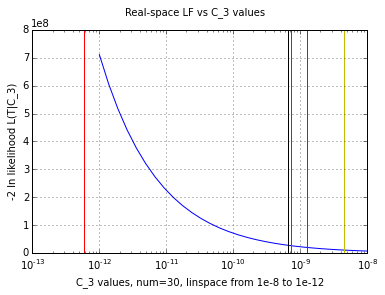

In [197]:
xaxis3 = vary_x_samples3
yaxis3 = LogLikehood_wNoise(vary_x_samples3, sigma3)


fig3 = plt.figure()
plt.plot(xaxis3, yaxis3)
plt.xscale("log")
fig3.suptitle('Real-space LF vs C_3 values')
plt.xlabel('C_3 values, num=30, linspace from 1e-8 to 1e-12')
plt.ylabel('-2 ln likelihood L(T|C_3)')
plt.axvline(x =1.25873313e-09, color = 'g')  # a30 = 1.25873313e-09
# plt.plt.axvline(x = 4.79243265e-17 ) # a31 = 4.79243265e-17 
plt.axvline(x =5.86460794e-13, color = 'r')  # a32 = 5.86460794e-13
plt.axvline(x =7.27453196e-10, color = 'm')  # a33 = 7.27453196e-10
plt.axvline(x =4.5454678088e-09, color = 'y') # 7*\hat{C}_3 = 4.5454678088e-09
plt.axvline(x =6.49352544114e-10, color = 'k')  # \hat{C}_3 = 6.49352544114e-10
plt.grid()

print "|a30|^2 is green, |a32|^2 is red, |a33|^2 is magenta, 7*\hat{C}_3 is yellow, \hat{C}_3 is black"

|a30|^2 is green, |a32|^2 is red, |a33|^2 is magenta, 7*\hat{C}_3 is yellow, \hat{C}_3 is black


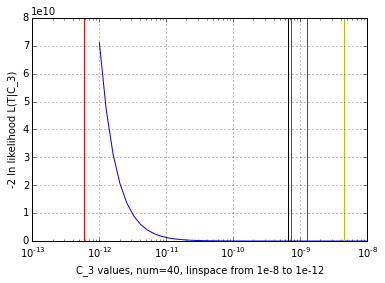

In [198]:
# Second test with rescaled values
vary_x_samples5 = np.logspace(-8, -12, num=40) #num = 40
sigma5 = np.logspace(-9, -16, num=40)

xaxis5 = vary_x_samples5
yaxis5 = LogLikehood_wNoise(vary_x_samples5, sigma5)

fig5 = plt.figure()
plt.plot(xaxis5, yaxis5)
plt.xscale("log")
plt.xlabel('C_3 values, num=40, linspace from 1e-8 to 1e-12')
plt.ylabel('-2 ln likelihood L(T|C_3)')
plt.axvline(x =1.25873313e-09, color = 'g')  # a30 = 1.25873313e-09
# plt.plt.axvline(x = 4.79243265e-17 ) # a31 = 4.79243265e-17 
plt.axvline(x =5.86460794e-13, color = 'r')  # a32 = 5.86460794e-13
plt.axvline(x =7.27453196e-10, color = 'm')  # a33 = 7.27453196e-10
plt.axvline(x =4.5454678088e-09, color = 'y') # 7*\hat{C}_3 = 4.5454678088e-09
plt.axvline(x =6.49352544114e-10, color = 'k')  # \hat{C}_3 = 6.49352544114e-10
plt.grid()

print "|a30|^2 is green, |a32|^2 is red, |a33|^2 is magenta, 7*\hat{C}_3 is yellow, \hat{C}_3 is black"

In [182]:
#########################################
#
# Plot the varied C_3 parameter from e-8 to e-12 (i.e. "vary_x_samples")
# for a range of noise parameters
#
########################################



|a30|^2 is green, |a32|^2 is red, |a33|^2 is magenta, 7*\hat{C}_3 is yellow, \hat{C}_3 is black


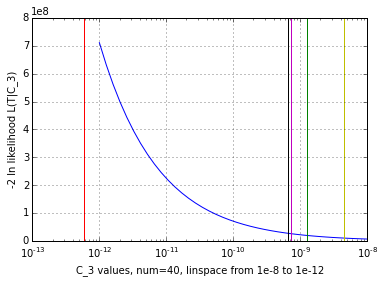

In [206]:
#
# Plot noise sigma from e-12 to e-14
#
vary_x_samples6 = np.logspace(-8, -12, num=40) #num = 40
sigma6 = np.logspace(-12, -14, num=40)

xaxis6 = vary_x_samples6
yaxis6 = LogLikehood_wNoise(vary_x_samples6, sigma6)

fig6 = plt.figure()
plt.plot(xaxis6, yaxis6)
plt.xscale("log")
plt.xlabel('C_3 values, num=40, linspace from 1e-8 to 1e-12')
plt.ylabel('-2 ln likelihood L(T|C_3)')
plt.axvline(x =1.25873313e-09, color = 'g')  # a30 = 1.25873313e-09
# plt.plt.axvline(x = 4.79243265e-17 ) # a31 = 4.79243265e-17 
plt.axvline(x =5.86460794e-13, color = 'r')  # a32 = 5.86460794e-13
plt.axvline(x =7.27453196e-10, color = 'm')  # a33 = 7.27453196e-10
plt.axvline(x =4.5454678088e-09, color = 'y') # 7*\hat{C}_3 = 4.5454678088e-09
plt.axvline(x =6.49352544114e-10, color = 'k')  # \hat{C}_3 = 6.49352544114e-10
plt.grid()

print "|a30|^2 is green, |a32|^2 is red, |a33|^2 is magenta, 7*\hat{C}_3 is yellow, \hat{C}_3 is black"

|a30|^2 is green, |a32|^2 is red, |a33|^2 is magenta, 7*\hat{C}_3 is yellow, \hat{C}_3 is black


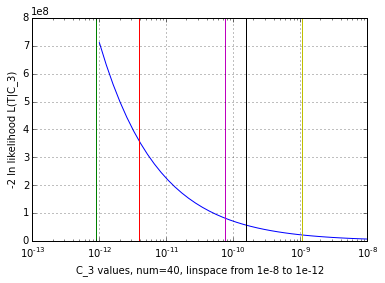

In [207]:
#
# Plot noise sigma from e-13 to e-15
#
vary_x_samples7 = np.logspace(-8, -12, num=40) #num = 40
sigma7 = np.logspace(-12, -14, num=40)

xaxis7 = vary_x_samples7
yaxis7 = LogLikehood_wNoise(vary_x_samples7, sigma7)

fig7 = plt.figure()
plt.plot(xaxis7, yaxis7)
plt.xscale("log")
plt.xlabel('C_3 values, num=40, linspace from 1e-8 to 1e-12')
plt.ylabel('-2 ln likelihood L(T|C_3)')
plt.axvline(x =8.84771791e-13, color = 'g')  # a30 = 8.84771791e-13
# plt.plt.axvline(x = 8.06516529e-18) # a31 = 8.06516529e-18
plt.axvline(x =3.85347491e-12, color = 'r')  # a32 = 3.85347491e-12
plt.axvline(x =7.58705140e-11, color = 'm')  # a33 = 7.58705140e-11
plt.axvline(x =1.07239080824e-09, color = 'y') # 7*\hat{C}_3 = 1.07239080824e-09
plt.axvline(x =1.53198686892e-10, color = 'k')  # \hat{C}_3 = 1.53198686892e-10
plt.grid()

print "|a30|^2 is green, |a32|^2 is red, |a33|^2 is magenta, 7*\hat{C}_3 is yellow, \hat{C}_3 is black"

|a30|^2 is green, |a32|^2 is red, |a33|^2 is magenta, 7*\hat{C}_3 is yellow, \hat{C}_3 is black


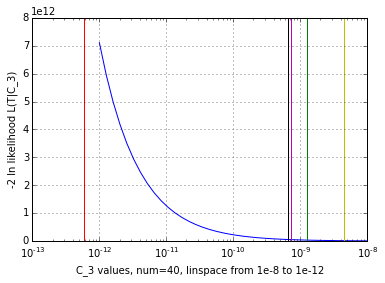

In [208]:
#
# Plot noise sigma from e-15 to e-18
#
vary_x_samples8 = np.logspace(-8, -12, num=40) #num = 40
sigma8 = np.logspace(-15, -18, num=40)

xaxis8 = vary_x_samples8
yaxis8 = LogLikehood_wNoise(vary_x_samples8, sigma8)

fig8 = plt.figure()
plt.plot(xaxis8, yaxis8)
plt.xscale("log")
plt.xlabel('C_3 values, num=40, linspace from 1e-8 to 1e-12')
plt.ylabel('-2 ln likelihood L(T|C_3)')
plt.axvline(x =1.25873313e-09, color = 'g')  # a30 = 1.25873313e-09
# plt.plt.axvline(x = 4.79243265e-17 ) # a31 = 4.79243265e-17 
plt.axvline(x =5.86460794e-13, color = 'r')  # a32 = 5.86460794e-13
plt.axvline(x =7.27453196e-10, color = 'm')  # a33 = 7.27453196e-10
plt.axvline(x =4.5454678088e-09, color = 'y') # 7*\hat{C}_3 = 4.5454678088e-09
plt.axvline(x =6.49352544114e-10, color = 'k')  # \hat{C}_3 = 6.49352544114e-10
plt.grid()

print "|a30|^2 is green, |a32|^2 is red, |a33|^2 is magenta, 7*\hat{C}_3 is yellow, \hat{C}_3 is black"

|a30|^2 is green, |a32|^2 is red, |a33|^2 is magenta, 7*\hat{C}_3 is yellow, \hat{C}_3 is black


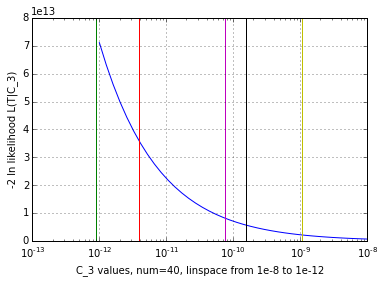

In [209]:
#
# Plot noise sigma from e-17 to e-19
#
vary_x_samples9 = np.logspace(-8, -12, num=40) #num = 40
sigma9 = np.logspace(-17, -19, num=40)

xaxis9 = vary_x_samples9
yaxis9 = LogLikehood_wNoise(vary_x_samples9, sigma9)

fig9 = plt.figure()
plt.plot(xaxis9, yaxis9)
plt.xscale("log")
plt.xlabel('C_3 values, num=40, linspace from 1e-8 to 1e-12')
plt.ylabel('-2 ln likelihood L(T|C_3)')
plt.axvline(x =8.84771791e-13, color = 'g')  # a30 = 8.84771791e-13
# plt.plt.axvline(x = 8.06516529e-18) # a31 = 8.06516529e-18
plt.axvline(x =3.85347491e-12, color = 'r')  # a32 = 3.85347491e-12
plt.axvline(x =7.58705140e-11, color = 'm')  # a33 = 7.58705140e-11
plt.axvline(x =1.07239080824e-09, color = 'y') # 7*\hat{C}_3 = 1.07239080824e-09
plt.axvline(x =1.53198686892e-10, color = 'k')  # \hat{C}_3 = 1.53198686892e-10
plt.grid()

print "|a30|^2 is green, |a32|^2 is red, |a33|^2 is magenta, 7*\hat{C}_3 is yellow, \hat{C}_3 is black"

|a30|^2 is green, |a32|^2 is red, |a33|^2 is magenta, 7*\hat{C}_3 is yellow, \hat{C}_3 is black


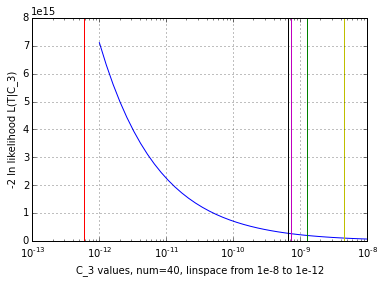

In [210]:
#
# Plot noise sigma from e-19 to e-21
#
vary_x_samples10 = np.logspace(-8, -12, num=40) #num = 40
sigma10 = np.logspace(-19, -21, num=40)

xaxis10 = vary_x_samples10
yaxis10 = LogLikehood_wNoise(vary_x_samples10, sigma10)

fig10 = plt.figure()
plt.plot(xaxis10, yaxis10)
plt.xscale("log")
plt.xlabel('C_3 values, num=40, linspace from 1e-8 to 1e-12')
plt.ylabel('-2 ln likelihood L(T|C_3)')
plt.axvline(x =1.25873313e-09, color = 'g')  # a30 = 1.25873313e-09
# plt.plt.axvline(x = 4.79243265e-17 ) # a31 = 4.79243265e-17 
plt.axvline(x =5.86460794e-13, color = 'r')  # a32 = 5.86460794e-13
plt.axvline(x =7.27453196e-10, color = 'm')  # a33 = 7.27453196e-10
plt.axvline(x =4.5454678088e-09, color = 'y') # 7*\hat{C}_3 = 4.5454678088e-09
plt.axvline(x =6.49352544114e-10, color = 'k')  # \hat{C}_3 = 6.49352544114e-10
plt.grid()

print "|a30|^2 is green, |a32|^2 is red, |a33|^2 is magenta, 7*\hat{C}_3 is yellow, \hat{C}_3 is black"

|a30|^2 is green, |a32|^2 is red, |a33|^2 is magenta, 7*\hat{C}_3 is yellow, \hat{C}_3 is black


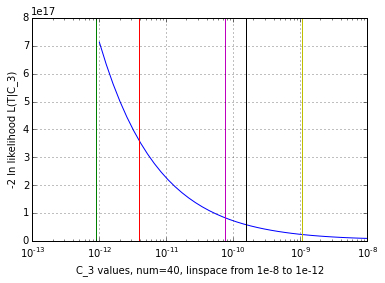

In [211]:
#
# Plot noise sigma from e-21 to e-223
#
vary_x_samples11 = np.logspace(-8, -12, num=40) #num = 40
sigma11 = np.logspace(-21, -23, num=40)

xaxis11 = vary_x_samples11
yaxis11 = LogLikehood_wNoise(vary_x_samples11, sigma11)

fig11 = plt.figure()
plt.plot(xaxis11, yaxis11)
plt.xscale("log")
plt.xlabel('C_3 values, num=40, linspace from 1e-8 to 1e-12')
plt.ylabel('-2 ln likelihood L(T|C_3)')
plt.axvline(x =8.84771791e-13, color = 'g')  # a30 = 8.84771791e-13
# plt.plt.axvline(x = 8.06516529e-18) # a31 = 8.06516529e-18
plt.axvline(x =3.85347491e-12, color = 'r')  # a32 = 3.85347491e-12
plt.axvline(x =7.58705140e-11, color = 'm')  # a33 = 7.58705140e-11
plt.axvline(x =1.07239080824e-09, color = 'y') # 7*\hat{C}_3 = 1.07239080824e-09
plt.axvline(x =1.53198686892e-10, color = 'k')  # \hat{C}_3 = 1.53198686892e-10
plt.grid()

print "|a30|^2 is green, |a32|^2 is red, |a33|^2 is magenta, 7*\hat{C}_3 is yellow, \hat{C}_3 is black"

|a30|^2 is green, |a32|^2 is red, |a33|^2 is magenta, 7*\hat{C}_3 is yellow, \hat{C}_3 is black


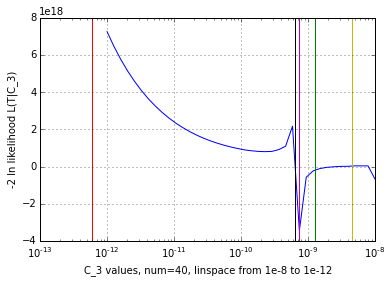

In [212]:
#
# Plot noise sigma from e-22 to e-24
#
vary_x_samples12 = np.logspace(-8, -12, num=40) #num = 40
sigma12 = np.logspace(-22, -24, num=40)

xaxis12 = vary_x_samples12
yaxis12 = LogLikehood_wNoise(vary_x_samples12, sigma12)

fig12 = plt.figure()
plt.plot(xaxis12, yaxis12)
plt.xscale("log")
plt.xlabel('C_3 values, num=40, linspace from 1e-8 to 1e-12')
plt.ylabel('-2 ln likelihood L(T|C_3)')
plt.axvline(x =1.25873313e-09, color = 'g')  # a30 = 1.25873313e-09
# plt.plt.axvline(x = 4.79243265e-17 ) # a31 = 4.79243265e-17 
plt.axvline(x =5.86460794e-13, color = 'r')  # a32 = 5.86460794e-13
plt.axvline(x =7.27453196e-10, color = 'm')  # a33 = 7.27453196e-10
plt.axvline(x =4.5454678088e-09, color = 'y') # 7*\hat{C}_3 = 4.5454678088e-09
plt.axvline(x =6.49352544114e-10, color = 'k')  # \hat{C}_3 = 6.49352544114e-10
plt.grid()

print "|a30|^2 is green, |a32|^2 is red, |a33|^2 is magenta, 7*\hat{C}_3 is yellow, \hat{C}_3 is black"

|a30|^2 is green, |a32|^2 is red, |a33|^2 is magenta, 7*\hat{C}_3 is yellow, \hat{C}_3 is black


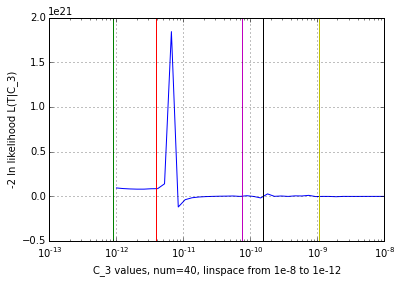

In [213]:
#
# Plot noise sigma from e-23 to e-25
#
vary_x_samples13 = np.logspace(-8, -12, num=40) #num = 40
sigma13 = np.logspace(-23, -25, num=40)

xaxis13 = vary_x_samples13
yaxis13 = LogLikehood_wNoise(vary_x_samples13, sigma13)

fig13 = plt.figure()
plt.plot(xaxis13, yaxis13)
plt.xscale("log")
plt.xlabel('C_3 values, num=40, linspace from 1e-8 to 1e-12')
plt.ylabel('-2 ln likelihood L(T|C_3)')
plt.axvline(x =8.84771791e-13, color = 'g')  # a30 = 8.84771791e-13
# plt.plt.axvline(x = 8.06516529e-18) # a31 = 8.06516529e-18
plt.axvline(x =3.85347491e-12, color = 'r')  # a32 = 3.85347491e-12
plt.axvline(x =7.58705140e-11, color = 'm')  # a33 = 7.58705140e-11
plt.axvline(x =1.07239080824e-09, color = 'y') # 7*\hat{C}_3 = 1.07239080824e-09
plt.axvline(x =1.53198686892e-10, color = 'k')  # \hat{C}_3 = 1.53198686892e-10
plt.grid()

print "|a30|^2 is green, |a32|^2 is red, |a33|^2 is magenta, 7*\hat{C}_3 is yellow, \hat{C}_3 is black"

|a30|^2 is green, |a32|^2 is red, |a33|^2 is magenta, 7*\hat{C}_3 is yellow, \hat{C}_3 is black


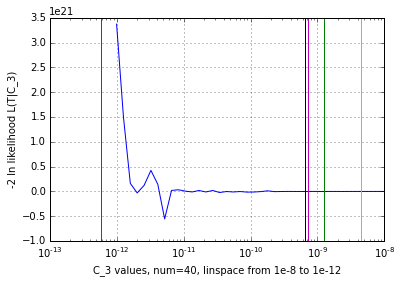

In [214]:
#
# Plot noise sigma from e-24 to e-26
#
vary_x_samples14 = np.logspace(-8, -12, num=40) #num = 40
sigma14 = np.logspace(-24, -26, num=40)

xaxis14 = vary_x_samples14
yaxis14 = LogLikehood_wNoise(vary_x_samples14, sigma14)

fig14 = plt.figure()
plt.plot(xaxis14, yaxis14)
plt.xscale("log")
plt.xlabel('C_3 values, num=40, linspace from 1e-8 to 1e-12')
plt.ylabel('-2 ln likelihood L(T|C_3)')
plt.axvline(x =1.25873313e-09, color = 'g')  # a30 = 1.25873313e-09
# plt.plt.axvline(x = 4.79243265e-17 ) # a31 = 4.79243265e-17 
plt.axvline(x =5.86460794e-13, color = 'r')  # a32 = 5.86460794e-13
plt.axvline(x =7.27453196e-10, color = 'm')  # a33 = 7.27453196e-10
plt.axvline(x =4.5454678088e-09, color = 'y') # 7*\hat{C}_3 = 4.5454678088e-09
plt.axvline(x =6.49352544114e-10, color = 'k')  # \hat{C}_3 = 6.49352544114e-10
plt.grid()

print "|a30|^2 is green, |a32|^2 is red, |a33|^2 is magenta, 7*\hat{C}_3 is yellow, \hat{C}_3 is black"

|a30|^2 is green, |a32|^2 is red, |a33|^2 is magenta, 7*\hat{C}_3 is yellow, \hat{C}_3 is black


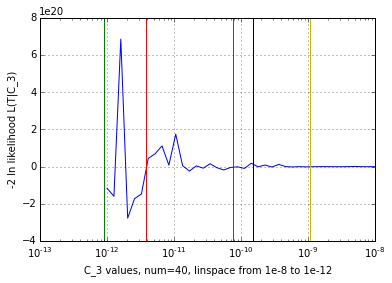

In [215]:
#
# Plot noise sigma from e-25 to e-27
#
vary_x_samples15 = np.logspace(-8, -12, num=40) #num = 40
sigma15 = np.logspace(-25, -27, num=40)

xaxis15 = vary_x_samples15
yaxis15 = LogLikehood_wNoise(vary_x_samples15, sigma15)

fig15 = plt.figure()
plt.plot(xaxis15, yaxis15)
plt.xscale("log")
plt.xlabel('C_3 values, num=40, linspace from 1e-8 to 1e-12')
plt.ylabel('-2 ln likelihood L(T|C_3)')
plt.axvline(x =8.84771791e-13, color = 'g')  # a30 = 8.84771791e-13
# plt.plt.axvline(x = 8.06516529e-18) # a31 = 8.06516529e-18
plt.axvline(x =3.85347491e-12, color = 'r')  # a32 = 3.85347491e-12
plt.axvline(x =7.58705140e-11, color = 'm')  # a33 = 7.58705140e-11
plt.axvline(x =1.07239080824e-09, color = 'y') # 7*\hat{C}_3 = 1.07239080824e-09
plt.axvline(x =1.53198686892e-10, color = 'k')  # \hat{C}_3 = 1.53198686892e-10
plt.grid()

print "|a30|^2 is green, |a32|^2 is red, |a33|^2 is magenta, 7*\hat{C}_3 is yellow, \hat{C}_3 is black"

|a30|^2 is green, |a32|^2 is red, |a33|^2 is magenta, 7*\hat{C}_3 is yellow, \hat{C}_3 is black


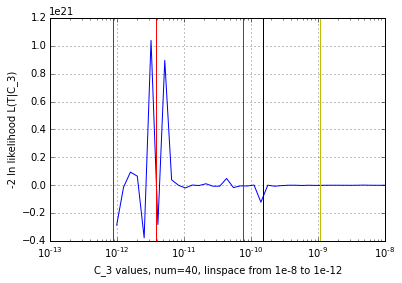

In [216]:
#
# Plot noise sigma from e-28 to e-30
#
vary_x_samples16 = np.logspace(-8, -12, num=40) #num = 40
sigma16 = np.logspace(-28, -30, num=40)

xaxis16 = vary_x_samples16
yaxis16 = LogLikehood_wNoise(vary_x_samples16, sigma16)

fig16 = plt.figure()
plt.plot(xaxis16, yaxis16)
plt.xscale("log")
plt.xlabel('C_3 values, num=40, linspace from 1e-8 to 1e-12')
plt.ylabel('-2 ln likelihood L(T|C_3)')
plt.axvline(x =8.84771791e-13, color = 'g')  # a30 = 8.84771791e-13
# plt.plt.axvline(x = 8.06516529e-18) # a31 = 8.06516529e-18
plt.axvline(x =3.85347491e-12, color = 'r')  # a32 = 3.85347491e-12
plt.axvline(x =7.58705140e-11, color = 'm')  # a33 = 7.58705140e-11
plt.axvline(x =1.07239080824e-09, color = 'y') # 7*\hat{C}_3 = 1.07239080824e-09
plt.axvline(x =1.53198686892e-10, color = 'k')  # \hat{C}_3 = 1.53198686892e-10
plt.grid()

print "|a30|^2 is green, |a32|^2 is red, |a33|^2 is magenta, 7*\hat{C}_3 is yellow, \hat{C}_3 is black"

In [217]:
print hatC3  # anafast generated C_l for l = 3 from sky map
print 7*hatC3
print C3     # CAMB generated C_3, Boltzmann code output
print alm3_squared

6.49352544114e-10
4.5454678088e-09
5.88275e-10
[  1.25873313e-09   4.79243265e-17   5.86460794e-13   7.27453196e-10]


In [218]:

print tempval.shape

(3072,)
